In [1]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import librosa
import IPython.display as ipd
from scipy.io import wavfile

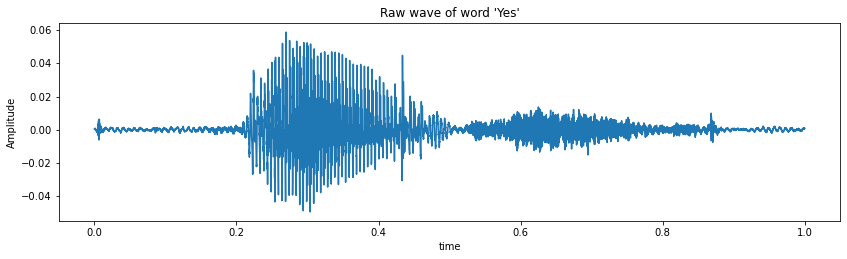

In [2]:
train_audio_path = './train/audio/'
samples, sample_rate = librosa.load(train_audio_path+'yes/00f0204f_nohash_0.wav', sr=16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of word \'Yes\'')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)
fig.show()

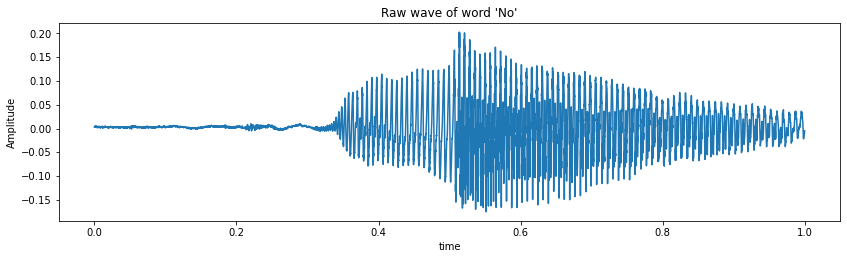

In [3]:
train_audio_path = './train/audio/'
samples, sample_rate = librosa.load(train_audio_path+'no/0a9f9af7_nohash_0.wav', sr=16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of word \'No\'')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)
fig.show()

In [4]:
sample_rate=40000
samples, sample_rate = librosa.load(train_audio_path+'yes/00f0204f_nohash_0.wav', sr=sample_rate)
ipd.Audio(samples, rate=sample_rate)

In [5]:
sample_rate=16000
samples, sample_rate = librosa.load(train_audio_path+'yes/00f0204f_nohash_0.wav', sr=sample_rate)
ipd.Audio(samples, rate=sample_rate)

In [6]:
sample_rate=6000
samples, sample_rate = librosa.load(train_audio_path+'yes/00f0204f_nohash_0.wav', sr=sample_rate)
ipd.Audio(samples, rate=sample_rate)

In [7]:
sample_rate=3000
samples, sample_rate = librosa.load(train_audio_path+'yes/00f0204f_nohash_0.wav', sr=sample_rate)
print(samples)
print(len(samples))
ipd.Audio(samples, rate=sample_rate)

[0.00033547 0.00048036 0.00028121 ... 0.00064596 0.00061304 0.0006926 ]
3000


In [8]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

In [9]:
labels=os.listdir(train_audio_path)

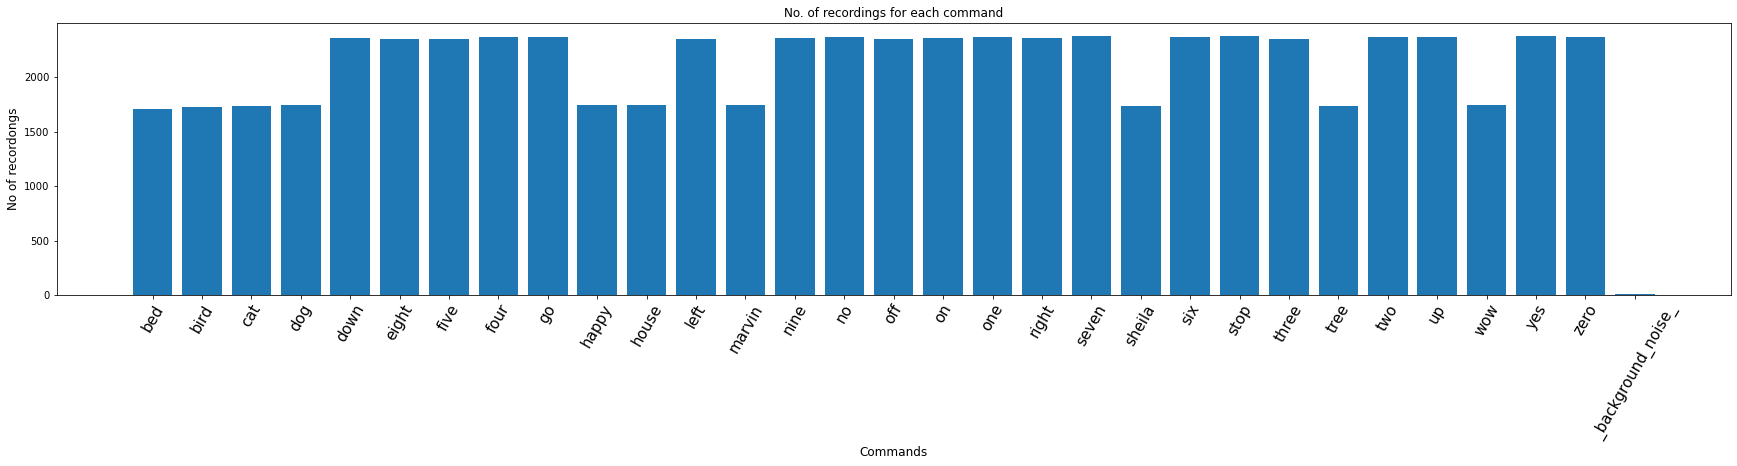

In [10]:
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/' + label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))

plt.figure(figsize=(30, 5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordongs', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()


In [11]:
labels=['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

In [31]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))
plt.show()

KeyboardInterrupt: 

In [12]:
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, orig_sr=sample_rate, target_sr=8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go


In [13]:
print(type(all_wave))
# print(all_wave.shape)
print(all_wave[1].shape)

<class 'list'>
(8000,)


In [14]:
len(set(all_label))

10

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(all_label)
classes = list(le.classes_)

In [16]:
classes

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']

In [17]:
from keras.utils import np_utils
y = np_utils.to_categorical(y, num_classes=len(labels))

In [18]:
print(y.shape)
print(y)

(21312, 10)
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [19]:
all_wave = np.array(all_wave).reshape(-1, 8000, 1)

In [20]:
all_wave.shape

(21312, 8000, 1)

In [23]:
from sklearn.model_selection import train_test_split
x_tr, x_test, y_tr, y_test = train_test_split(np.array(all_wave), np.array(y),
                                            stratify=y, test_size=0.2, random_state=777,
                                            shuffle=True)
x_test, x_val, y_test, y_val = train_test_split(np.array(x_test), np.array(y_test),
                                             stratify=y_test, test_size=0.5, random_state=777,
                                                shuffle=True)
print(len(x_tr))
print(len(x_val))
print(len(x_test))

17049
2132
2131


In [24]:

from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
# K.clear_session()

In [25]:
inputs = Input(shape=(8000, 1))

#First Conv1D layer
conv = Conv1D(filters=8,kernel_size=13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2662, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 884, 16)          0         
 1D)                                                         

In [26]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [27]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [28]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/100
533/533 [==============================] - 93s 170ms/step - loss: 2.0217 - accuracy: 0.2327 - val_loss: 1.6297 - val_accuracy: 0.4386
Epoch 2/100
533/533 [==============================] - 88s 165ms/step - loss: 1.4936 - accuracy: 0.4448 - val_loss: 1.3034 - val_accuracy: 0.5385
Epoch 3/100
533/533 [==============================] - 91s 171ms/step - loss: 1.2503 - accuracy: 0.5461 - val_loss: 1.1131 - val_accuracy: 0.6060
Epoch 4/100
533/533 [==============================] - 93s 175ms/step - loss: 1.0859 - accuracy: 0.6153 - val_loss: 1.0634 - val_accuracy: 0.6234
Epoch 5/100
533/533 [==============================] - 92s 173ms/step - loss: 0.9816 - accuracy: 0.6587 - val_loss: 0.8697 - val_accuracy: 0.6993
Epoch 6/100
533/533 [==============================] - 93s 174ms/step - loss: 0.8785 - accuracy: 0.6996 - val_loss: 0.7942 - val_accuracy: 0.7205
Epoch 7/100
533/533 [==============================] - 93s 174ms/step - loss: 0.7973 - accuracy: 0.7249 - val_loss: 0.7906 -

533/533 [==============================] - 89s 167ms/step - loss: 0.3669 - accuracy: 0.8752 - val_loss: 0.4998 - val_accuracy: 0.8391
Epoch 28/100
533/533 [==============================] - 90s 169ms/step - loss: 0.3591 - accuracy: 0.8761 - val_loss: 0.5061 - val_accuracy: 0.8410
Epoch 29/100
533/533 [==============================] - 107s 200ms/step - loss: 0.3412 - accuracy: 0.8840 - val_loss: 0.4867 - val_accuracy: 0.8396
Epoch 30/100
533/533 [==============================] - 126s 236ms/step - loss: 0.3366 - accuracy: 0.8859 - val_loss: 0.4991 - val_accuracy: 0.8429
Epoch 31/100
533/533 [==============================] - 133s 249ms/step - loss: 0.3302 - accuracy: 0.8843 - val_loss: 0.5936 - val_accuracy: 0.8100
Epoch 32/100
533/533 [==============================] - 132s 248ms/step - loss: 0.3309 - accuracy: 0.8866 - val_loss: 0.5744 - val_accuracy: 0.8157
Epoch 33/100
533/533 [==============================] - 130s 245ms/step - loss: 0.3166 - accuracy: 0.8899 - val_loss: 0.5047 - 

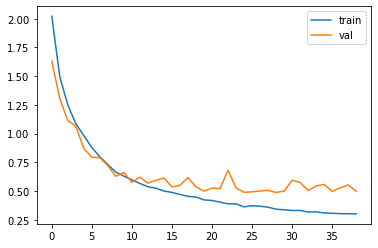

In [30]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

In [53]:
# model.save('SpeechRecogModel.h5')

In [14]:
from tensorflow import keras
model = keras.models.load_model('SpeechRecogModel.h5')

In [15]:
model.save('saved_model')

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


In [36]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    print(index)
    return classes[index]

In [37]:
y_pred = [predict(i) for i in x_test]
print(y_pred)

# test_acc = sum(y_pred == y_test) / len(y_test)
# print(f'Test set accuracy: {test_acc:.0%}')

1/1 [==============================] - 0s 28ms/step
7
1/1 [==============================] - 0s 26ms/step
0
1/1 [==============================] - 0s 28ms/step
8
1/1 [==============================] - 0s 31ms/step
4
1/1 [==============================] - 0s 27ms/step
4
1/1 [==============================] - 0s 25ms/step
3
1/1 [==============================] - 0s 32ms/step
1
1/1 [==============================] - 0s 25ms/step
4
1/1 [==============================] - 0s 33ms/step
0
1/1 [==============================] - 0s 33ms/step
9
1/1 [==============================] - 0s 32ms/step
7
1/1 [==============================] - 0s 25ms/step
6
1/1 [==============================] - 0s 35ms/step
9
1/1 [==============================] - 0s 38ms/step
8
1/1 [==============================] - 0s 24ms/step
1
1/1 [==============================] - 0s 24ms/step
5
1/1 [==============================] - 0s 42ms/step
2
1/1 [==============================] - 0s 34ms/step
5
1/1 [=======================

1/1 [==============================] - 0s 28ms/step
9
1/1 [==============================] - 0s 26ms/step
9
1/1 [==============================] - 0s 24ms/step
6
1/1 [==============================] - 0s 25ms/step
2
1/1 [==============================] - 0s 28ms/step
1
1/1 [==============================] - 0s 26ms/step
6
1/1 [==============================] - 0s 27ms/step
2
1/1 [==============================] - 0s 25ms/step
5
1/1 [==============================] - 0s 26ms/step
9
1/1 [==============================] - 0s 26ms/step
9
1/1 [==============================] - 0s 25ms/step
8
1/1 [==============================] - 0s 25ms/step
4
1/1 [==============================] - 0s 27ms/step
5
1/1 [==============================] - 0s 31ms/step
8
1/1 [==============================] - 0s 33ms/step
9
1/1 [==============================] - 0s 24ms/step
8
1/1 [==============================] - 0s 25ms/step
9
1/1 [==============================] - 0s 26ms/step
7
1/1 [=======================

1/1 [==============================] - 0s 26ms/step
5
1/1 [==============================] - 0s 23ms/step
0
1/1 [==============================] - 0s 24ms/step
5
1/1 [==============================] - 0s 25ms/step
0
1/1 [==============================] - 0s 27ms/step
7
1/1 [==============================] - 0s 25ms/step
4
1/1 [==============================] - 0s 28ms/step
5
1/1 [==============================] - 0s 26ms/step
7
1/1 [==============================] - 0s 29ms/step
1
1/1 [==============================] - 0s 26ms/step
2
1/1 [==============================] - 0s 24ms/step
9
1/1 [==============================] - 0s 24ms/step
4
1/1 [==============================] - 0s 27ms/step
5
1/1 [==============================] - 0s 29ms/step
6
1/1 [==============================] - 0s 25ms/step
1
1/1 [==============================] - 0s 25ms/step
8
1/1 [==============================] - 0s 25ms/step
5
1/1 [==============================] - 0s 27ms/step
2
1/1 [=======================

1/1 [==============================] - 0s 30ms/step
1
1/1 [==============================] - 0s 27ms/step
0
1/1 [==============================] - 0s 27ms/step
0
1/1 [==============================] - 0s 25ms/step
0
1/1 [==============================] - 0s 29ms/step
8
1/1 [==============================] - 0s 28ms/step
8
1/1 [==============================] - 0s 25ms/step
7
1/1 [==============================] - 0s 25ms/step
4
1/1 [==============================] - 0s 25ms/step
3
1/1 [==============================] - 0s 25ms/step
0
1/1 [==============================] - 0s 31ms/step
2
1/1 [==============================] - 0s 25ms/step
2
1/1 [==============================] - 0s 26ms/step
3
1/1 [==============================] - 0s 25ms/step
7
1/1 [==============================] - 0s 28ms/step
9
1/1 [==============================] - 0s 28ms/step
9
1/1 [==============================] - 0s 28ms/step
3
1/1 [==============================] - 0s 26ms/step
6
1/1 [=======================

1/1 [==============================] - 0s 26ms/step
9
1/1 [==============================] - 0s 28ms/step
9
1/1 [==============================] - 0s 26ms/step
4
1/1 [==============================] - 0s 25ms/step
9
1/1 [==============================] - 0s 24ms/step
8
1/1 [==============================] - 0s 26ms/step
0
1/1 [==============================] - 0s 30ms/step
9
1/1 [==============================] - 0s 24ms/step
7
1/1 [==============================] - 0s 26ms/step
9
1/1 [==============================] - 0s 28ms/step
7
1/1 [==============================] - 0s 25ms/step
6
1/1 [==============================] - 0s 24ms/step
6
1/1 [==============================] - 0s 25ms/step
9
1/1 [==============================] - 0s 25ms/step
0
1/1 [==============================] - 0s 26ms/step
3
1/1 [==============================] - 0s 27ms/step
6
1/1 [==============================] - 0s 26ms/step
0
1/1 [==============================] - 0s 25ms/step
8
1/1 [=======================

1/1 [==============================] - 0s 25ms/step
0
1/1 [==============================] - 0s 25ms/step
5
1/1 [==============================] - 0s 26ms/step
5
1/1 [==============================] - 0s 30ms/step
8
1/1 [==============================] - 0s 26ms/step
2
1/1 [==============================] - 0s 26ms/step
2
1/1 [==============================] - 0s 26ms/step
0
1/1 [==============================] - 0s 26ms/step
7
1/1 [==============================] - 0s 27ms/step
3
1/1 [==============================] - 0s 28ms/step
2
1/1 [==============================] - 0s 24ms/step
5
1/1 [==============================] - 0s 31ms/step
8
1/1 [==============================] - 0s 25ms/step
5
1/1 [==============================] - 0s 27ms/step
7
1/1 [==============================] - 0s 26ms/step
8
1/1 [==============================] - 0s 27ms/step
5
1/1 [==============================] - 0s 26ms/step
6
1/1 [==============================] - 0s 27ms/step
4
1/1 [=======================

1/1 [==============================] - 0s 26ms/step
8
1/1 [==============================] - 0s 27ms/step
9
1/1 [==============================] - 0s 26ms/step
9
1/1 [==============================] - 0s 25ms/step
6
1/1 [==============================] - 0s 25ms/step
1
1/1 [==============================] - 0s 25ms/step
6
1/1 [==============================] - 0s 24ms/step
3
1/1 [==============================] - 0s 26ms/step
4
1/1 [==============================] - 0s 26ms/step
9
1/1 [==============================] - 0s 24ms/step
2
1/1 [==============================] - 0s 26ms/step
8
1/1 [==============================] - 0s 24ms/step
9
1/1 [==============================] - 0s 27ms/step
9
1/1 [==============================] - 0s 24ms/step
5
1/1 [==============================] - 0s 26ms/step
0
1/1 [==============================] - 0s 25ms/step
6
1/1 [==============================] - 0s 26ms/step
3
1/1 [==============================] - 0s 24ms/step
3
1/1 [=======================

1/1 [==============================] - 0s 65ms/step
7
1/1 [==============================] - 0s 62ms/step
7
1/1 [==============================] - 0s 35ms/step
4
1/1 [==============================] - 0s 60ms/step
6
1/1 [==============================] - 0s 37ms/step
2
1/1 [==============================] - 0s 49ms/step
1
1/1 [==============================] - 0s 37ms/step
6
1/1 [==============================] - 0s 35ms/step
7
1/1 [==============================] - 0s 70ms/step
8
1/1 [==============================] - 0s 58ms/step
9
1/1 [==============================] - 0s 72ms/step
5
1/1 [==============================] - 0s 59ms/step
4
1/1 [==============================] - 0s 54ms/step
5
1/1 [==============================] - 0s 48ms/step
5
1/1 [==============================] - 0s 40ms/step
5
1/1 [==============================] - 0s 66ms/step
3
1/1 [==============================] - 0s 30ms/step
0
1/1 [==============================] - 0s 47ms/step
0
1/1 [=======================

1/1 [==============================] - 0s 27ms/step
2
1/1 [==============================] - 0s 29ms/step
0
1/1 [==============================] - 0s 32ms/step
3
1/1 [==============================] - 0s 33ms/step
4
1/1 [==============================] - 0s 30ms/step
6
1/1 [==============================] - 0s 30ms/step
3
1/1 [==============================] - 0s 25ms/step
2
1/1 [==============================] - 0s 68ms/step
1
1/1 [==============================] - 0s 125ms/step
4
1/1 [==============================] - 0s 50ms/step
7
1/1 [==============================] - 0s 60ms/step
3
1/1 [==============================] - 0s 61ms/step
1
1/1 [==============================] - 0s 41ms/step
2
1/1 [==============================] - 0s 45ms/step
1
1/1 [==============================] - 0s 30ms/step
9
1/1 [==============================] - 0s 33ms/step
3
1/1 [==============================] - 0s 32ms/step
1
1/1 [==============================] - 0s 32ms/step
3
1/1 [======================

1/1 [==============================] - 0s 31ms/step
9
1/1 [==============================] - 0s 30ms/step
6
1/1 [==============================] - 0s 30ms/step
3
1/1 [==============================] - 0s 47ms/step
2
1/1 [==============================] - 0s 32ms/step
0
1/1 [==============================] - 0s 38ms/step
8
1/1 [==============================] - 0s 32ms/step
2
1/1 [==============================] - 0s 33ms/step
2
1/1 [==============================] - 0s 31ms/step
3
1/1 [==============================] - 0s 33ms/step
9
1/1 [==============================] - 0s 36ms/step
9
1/1 [==============================] - 0s 35ms/step
5
1/1 [==============================] - 0s 52ms/step
3
1/1 [==============================] - 0s 32ms/step
6
1/1 [==============================] - 0s 38ms/step
8
1/1 [==============================] - 0s 36ms/step
7
1/1 [==============================] - 0s 34ms/step
5
1/1 [==============================] - 0s 30ms/step
0
1/1 [=======================

1/1 [==============================] - 0s 31ms/step
4
1/1 [==============================] - 0s 31ms/step
4
1/1 [==============================] - 0s 36ms/step
1
1/1 [==============================] - 0s 34ms/step
1
1/1 [==============================] - 0s 35ms/step
6
1/1 [==============================] - 0s 34ms/step
9
1/1 [==============================] - 0s 49ms/step
9
1/1 [==============================] - 0s 33ms/step
9
1/1 [==============================] - 0s 31ms/step
3
1/1 [==============================] - 0s 37ms/step
6
1/1 [==============================] - 0s 31ms/step
6
1/1 [==============================] - 0s 35ms/step
3
1/1 [==============================] - 0s 34ms/step
1
1/1 [==============================] - 0s 33ms/step
6
1/1 [==============================] - 0s 31ms/step
6
1/1 [==============================] - 0s 42ms/step
7
1/1 [==============================] - 0s 36ms/step
2
1/1 [==============================] - 0s 35ms/step
1
1/1 [=======================

1/1 [==============================] - 0s 34ms/step
3
1/1 [==============================] - 0s 31ms/step
0
1/1 [==============================] - 0s 30ms/step
6
1/1 [==============================] - 0s 30ms/step
8
1/1 [==============================] - 0s 32ms/step
3
1/1 [==============================] - 0s 31ms/step
6
1/1 [==============================] - 0s 32ms/step
3
1/1 [==============================] - 0s 29ms/step
2
1/1 [==============================] - 0s 34ms/step
3
1/1 [==============================] - 0s 33ms/step
4
1/1 [==============================] - 0s 34ms/step
4
1/1 [==============================] - 0s 29ms/step
4
1/1 [==============================] - 0s 32ms/step
9
1/1 [==============================] - 0s 34ms/step
1
1/1 [==============================] - 0s 32ms/step
7
1/1 [==============================] - 0s 48ms/step
1
1/1 [==============================] - 0s 49ms/step
0
1/1 [==============================] - 0s 33ms/step
8
1/1 [=======================

1/1 [==============================] - 0s 25ms/step
1
1/1 [==============================] - 0s 25ms/step
7
1/1 [==============================] - 0s 27ms/step
5
1/1 [==============================] - 0s 24ms/step
2
1/1 [==============================] - 0s 25ms/step
2
1/1 [==============================] - 0s 27ms/step
1
1/1 [==============================] - 0s 30ms/step
8
1/1 [==============================] - 0s 31ms/step
4
1/1 [==============================] - 0s 27ms/step
9
1/1 [==============================] - 0s 25ms/step
2
1/1 [==============================] - 0s 40ms/step
8
1/1 [==============================] - 0s 27ms/step
9
1/1 [==============================] - 0s 29ms/step
4
1/1 [==============================] - 0s 41ms/step
1
1/1 [==============================] - 0s 31ms/step
1
1/1 [==============================] - 0s 29ms/step
0
1/1 [==============================] - 0s 26ms/step
7
1/1 [==============================] - 0s 24ms/step
6
1/1 [=======================

1/1 [==============================] - 0s 32ms/step
1
1/1 [==============================] - 0s 34ms/step
3
1/1 [==============================] - 0s 78ms/step
8
1/1 [==============================] - 0s 34ms/step
2
1/1 [==============================] - 0s 39ms/step
5
1/1 [==============================] - 0s 34ms/step
2
1/1 [==============================] - 0s 42ms/step
5
1/1 [==============================] - 0s 43ms/step
3
1/1 [==============================] - 0s 36ms/step
7
1/1 [==============================] - 0s 33ms/step
4
1/1 [==============================] - 0s 37ms/step
1
1/1 [==============================] - 0s 35ms/step
5
1/1 [==============================] - 0s 46ms/step
6
1/1 [==============================] - 0s 47ms/step
8
1/1 [==============================] - 0s 33ms/step
2
1/1 [==============================] - 0s 35ms/step
0
1/1 [==============================] - 0s 36ms/step
0
1/1 [==============================] - 0s 36ms/step
0
1/1 [=======================

1/1 [==============================] - 0s 30ms/step
8
1/1 [==============================] - 0s 36ms/step
3
1/1 [==============================] - 0s 37ms/step
2
1/1 [==============================] - 0s 45ms/step
6
1/1 [==============================] - 0s 38ms/step
1
1/1 [==============================] - 0s 33ms/step
4
1/1 [==============================] - 0s 32ms/step
5
1/1 [==============================] - 0s 33ms/step
0
1/1 [==============================] - 0s 34ms/step
2
1/1 [==============================] - 0s 34ms/step
2
1/1 [==============================] - 0s 36ms/step
6
1/1 [==============================] - 0s 35ms/step
9
1/1 [==============================] - 0s 32ms/step
0
1/1 [==============================] - 0s 33ms/step
8
1/1 [==============================] - 0s 30ms/step
3
1/1 [==============================] - 0s 34ms/step
1
1/1 [==============================] - 0s 34ms/step
2
['stop', 'down', 'up', 'off', 'off', 'no', 'go', 'off', 'down', 'yes', 'stop', 'ri

In [43]:
arr = [classes[np.argmax(y_test[i])] for i in range(len(y_test))]


In [45]:
test_acc = sum(np.array(y_pred) == np.array(arr)) / len(arr)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 84%


In [79]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: off


In [80]:
print(samples)
print(len(samples))

[0.00236257 0.00421104 0.00489744 ... 0.00564968 0.00543255 0.00331187]
8000


In [81]:
print("Text:",predict(samples))

1/1 [==============================] - 0s 31ms/step
4
Text: off


In [74]:
!pip install sounddevice==0.2.1

  Using cached sounddevice-0.2.1-py2.py3.cp26.cp27.cp32.cp33.cp34.cp35.pp27.pp32-none-win_amd64.whl (413 kB)


In [75]:
import sounddevice as sd
import soundfile as sf

In [77]:
samplerate = 16000  
duration = 1 # seconds
filename = 'yes.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


In [ ]:
#reading the voice commands
samples, sample_rate = librosa.load(filepath + '/' + 'stop.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)  